In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

2024-07-24 04:34:18.463429: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 04:34:18.463579: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 04:34:18.604107: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

## Generator

In [3]:
train_ds = keras.utils.image_dataset_from_directory(
    directory='/kaggle/input/tomatoleaf/tomato/train',
    labels = 'inferred',
    image_size=(256, 256),
    batch_size=32,
    shuffle = True,
    label_mode='categorical'
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory='/kaggle/input/tomatoleaf/tomato/val',
    labels = 'inferred',
    image_size=(256, 256),
    batch_size=32,
    shuffle = False,
    label_mode='categorical'
)
# Get the class names
class_names = validation_ds.class_names
print("Class names:", class_names)

Found 10000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.
Class names: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [4]:
#import tensorflow_addons as tfa

# Define the augmentation function
def augment(image, label):
    image = tf.image.random_flip_left_right(image)  # Randomly flip image horizontally
    image = tf.image.random_flip_up_down(image)    # Randomly flip image vertically
    image = tf.image.random_brightness(image, max_delta=0.1)  # Randomly adjust brightness
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # Randomly adjust contrast
    angle = tf.random.uniform(shape=[], minval=-0.1, maxval=0.1)  # Random angle in radians
    #image = tfa.image.rotate(image, angles=angle)  # Randomly rotate image
    return image, label

In [5]:
def rotate(image, label):
    # Randomly choose an angle between -45 and 45 degrees
    angles = tf.random.uniform([], minval=-np.pi/4, maxval=np.pi/4)
    
    # Convert the angles from degrees to radians
    radians = angles * np.pi / 180.0
    
    # Rotate the image
    image = tf.image.rot90(image, k=tf.cast(radians // (np.pi/2), tf.int32)) # For 90 degree increments
    
    # This can be further refined for more fine-grained rotation
    # For simplicity here, we are using rot90 which rotates by 90 degrees
    return image, label

In [6]:
def process(image, label):
    
    image = tf.cast(image/255, tf.float32)
    return image, label

train_ds = train_ds.map(augment).map(process).map(rotate)
validation_ds = validation_ds.map(process)

train_ds = train_ds.shuffle(1000).prefetch(tf.data.AUTOTUNE)
validation_ds = validation_ds.prefetch(tf.data.AUTOTUNE)

## Create CNN Model

In [7]:
model = Sequential()

model.add(Conv2D(32, kernel_size = (3,3), padding = 'valid', activation = 'relu', input_shape = (256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'valid'))

model.add(Conv2D(64, kernel_size = (3,3), padding = 'valid', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'valid'))

model.add(Conv2D(128, kernel_size = (3,3), padding = 'valid', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'valid'))

model.add(Flatten())

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(10, activation = 'softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,778 (56.64 MB)

 Trainable params: 14,848,330 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [8]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

history = model.fit(train_ds, epochs=6, validation_data=validation_ds, callbacks=[early_stopping, model_checkpoint])


Epoch 1/6
  2/313 ━━━━━━━━━━━━━━━━━━━━ 28s 92ms/step - accuracy: 0.1328 - loss: 3.8728   

I0000 00:00:1721795726.639875      81 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721795726.666054      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.4717 - loss: 1.9009

W0000 00:00:1721795759.753213      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 117ms/step - accuracy: 0.4720 - loss: 1.8992 - val_accuracy: 0.1580 - val_loss: 9.6471
Epoch 2/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 47s 75ms/step - accuracy: 0.7023 - loss: 0.9001 - val_accuracy: 0.7650 - val_loss: 0.6907
Epoch 3/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 47s 76ms/step - accuracy: 0.7665 - loss: 0.7567 - val_accuracy: 0.8540 - val_loss: 0.5258
Epoch 4/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 48s 76ms/step - accuracy: 0.8007 - loss: 0.6459 - val_accuracy: 0.8540 - val_loss: 0.4603
Epoch 5/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 47s 73ms/step - accuracy: 0.8138 - loss: 0.5943 - val_accuracy: 0.8450 - val_loss: 0.5310
Epoch 6/6
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 73ms/step - accuracy: 0.8385 - loss: 0.5207 - val_accuracy: 0.7890 - val_loss: 0.7050


In [9]:
# Get true labels and predicted labels
true_labels = []
predicted_labels = []

for images, labels in validation_ds:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))
    preds = model.predict(images)
    predicted_labels.extend(np.argmax(preds, axis=1))

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


W0000 00:00:1721796000.250381      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

In [10]:
# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print the confusion matrix
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[ 94   3   0   0   1   0   0   2   0   0]
 [ 10  65   2   8   0   1  11   2   1   0]
 [  1  11  75   5   5   1   1   1   0   0]
 [  0   0   2  92   0   0   0   0   4   2]
 [  0   2   2  10  75   1   6   0   4   0]
 [  0   0   0   1   0  81  14   0   4   0]
 [  0   0   0   0   0   7  90   0   3   0]
 [  1   1   1   5   1   4   0  87   0   0]
 [  0   0   0   0   0   0   0   0 100   0]
 [  0   0   0   0   0   0   3   0   2  95]]


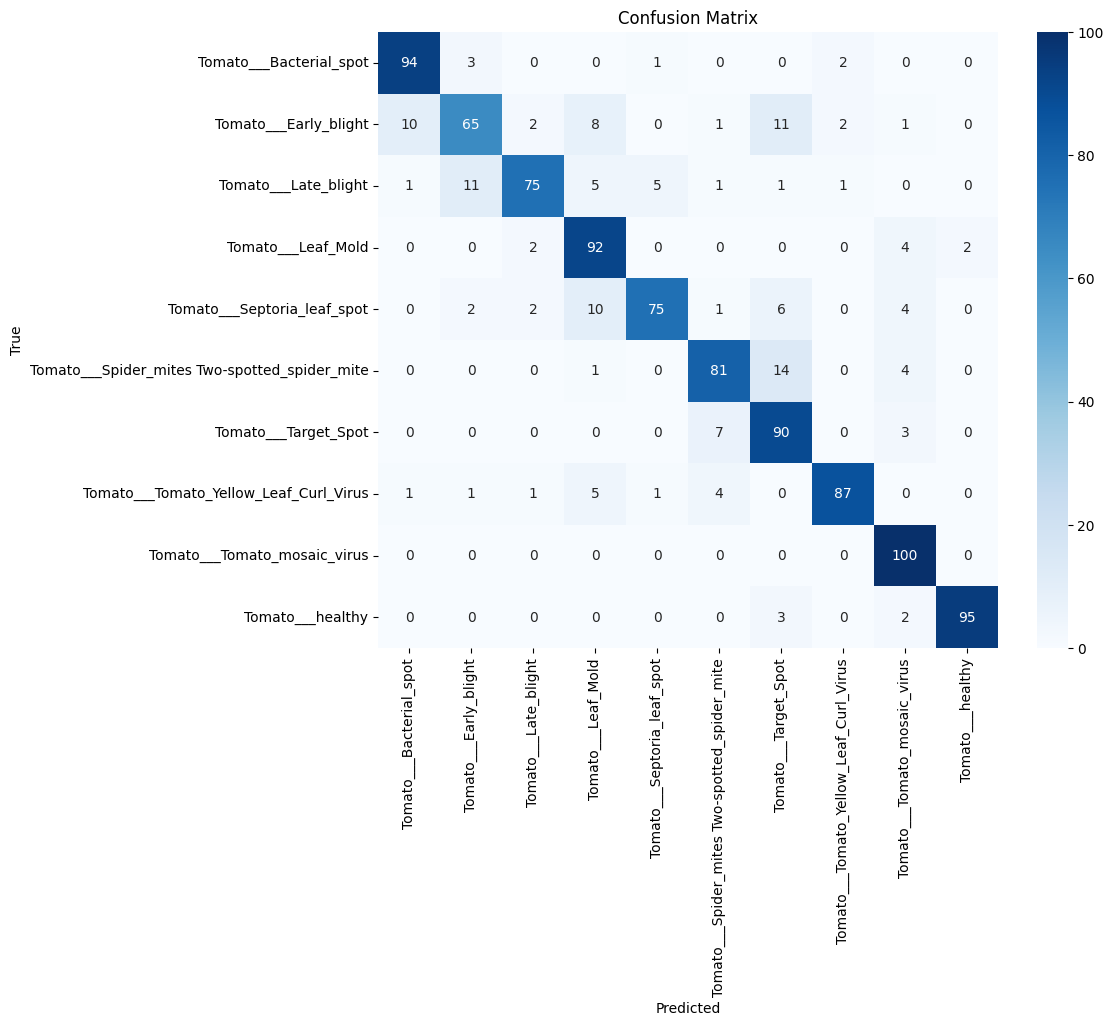

In [11]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Plots to show accuracy

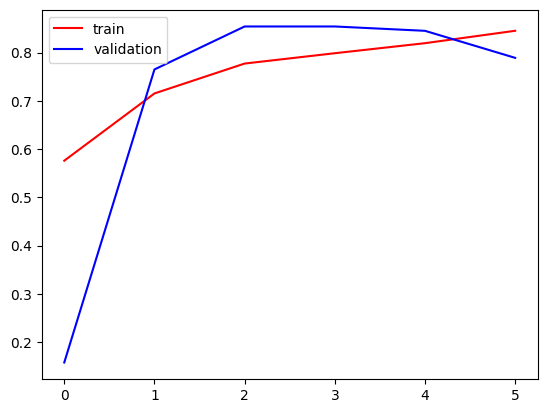

In [12]:
plt.plot(history.history['accuracy'], color = 'red', label = 'train')
plt.plot(history.history['val_accuracy'], color="blue", label = 'validation')
plt.legend()
plt.show()

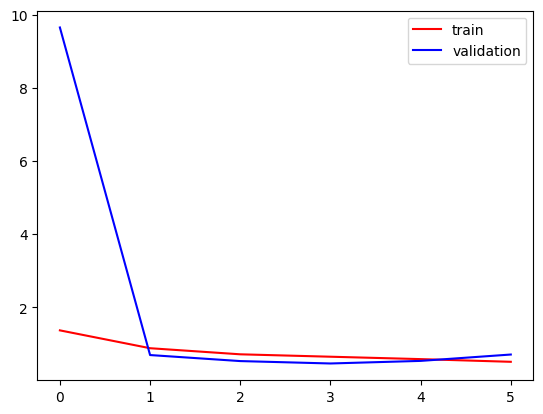

In [13]:
plt.plot(history.history['loss'], color='red', label='train')
plt.plot(history.history['val_loss'], color="blue", label = 'validation')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


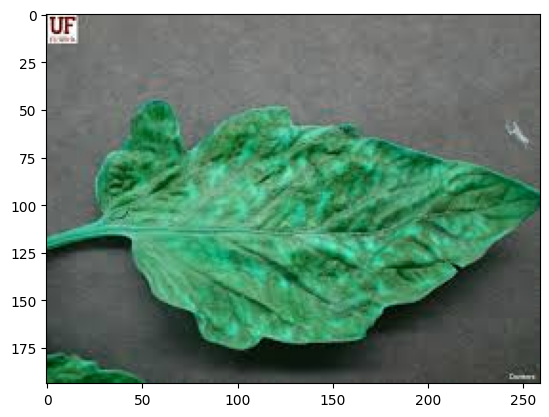

In [14]:
import cv2
test_img = cv2.imread('/kaggle/input/test-image/mosaic.png')
plt.imshow(test_img)
test_img.shape
test_img = cv2.resize(test_img, (256,256))
test_input = test_img.reshape((1, 256, 256,3))
value = model.predict(test_input)
print(value)